In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import mlflow

import sys
import os

sys.path.append(os.path.abspath(os.path.join('../src')))
from experiment import run_experiment
from helper_functions import generate_random_string

In [2]:
mlflow.set_tracking_uri("http://localhost:5001")

In [3]:
df = pd.read_csv("../data/raw_games.csv").dropna()

In [4]:
total_probs = (1 / df['b365h']) + (1 / df['b365d']) + (1 / df['b365a'])
df['bookies_prob_h'] = 1 / df['b365h'] / total_probs 
df['bookies_prob_d'] = 1 / df['b365d'] / total_probs 
df['bookies_prob_a'] = 1 / df['b365a'] / total_probs 

In [5]:
def expected_score(rating_1, rating_2):
    return 1 / (1 + 10 ** ((rating_1 - rating_2) / 400))

In [6]:
def expected_score(rating_1, rating_2):
    return 1 / (1 + 10 ** ((rating_2 - rating_1) / 400))

teams = pd.concat([df['hometeam'], df['awayteam']]).unique()
elo_ratings = {team: 1500 for team in teams}
K = 20

elo_h_before = []
elo_a_before = []
elo_h_after = []
elo_a_after = []
elo_prob_h = []
elo_prob_a = []

for index, row in df.iterrows():
    elo_h = elo_ratings[row['hometeam']]
    elow_a = elo_ratings[row['awayteam']]

    elo_h_before.append(elo_h)
    elo_a_before.append(elow_a)
    
    exp_h = expected_score(elo_h, elow_a)
    exp_a = expected_score(elow_a, elo_h)
    elo_prob_h.append(exp_h)
    elo_prob_a.append(exp_a)

    score_home = int(row['ftr'] == 'H') + 0.5 * int(row['ftr'] == 'D')
    score_away = int(row['ftr'] == 'A') + 0.5 * int(row['ftr'] == 'D')
    
    elo_h_new = elo_h + K * (score_home - exp_h)
    elo_a_new = elow_a + K * (score_away - exp_a)
    
    elo_ratings[row['hometeam']] = elo_h_new
    elo_ratings[row['awayteam']] = elo_a_new
    elo_h_after.append(elo_h_new)
    elo_a_after.append(elo_a_new)

df['elo_h_before'] = elo_h_before
df['elo_a_before'] = elo_a_before
df['elo_h_after'] = elo_h_after
df['elo_a_after'] = elo_a_after
df['elo_prob_h'] = elo_prob_h
df['elo_prob_a'] = elo_prob_a

ratings_df = pd.DataFrame(list(elo_ratings.items()), columns=['Team', 'Elo'])
ratings_df = ratings_df.sort_values(by='Elo', ascending=False).reset_index().drop(columns=["index"])

print("\nTop 5:")
print(ratings_df.head(5))
print("\nBottom 5:")
print( ratings_df.tail(5))




Top 5:
        Team          Elo
0  Liverpool  1794.024722
1    Arsenal  1787.939045
2   Man City  1767.358485
3    Chelsea  1645.655386
4  Newcastle  1630.438552

Bottom 5:
                Team          Elo
36               QPR  1380.760456
37       Southampton  1365.110820
38      Huddersfield  1359.967925
39  Sheffield United  1359.713392
40           Norwich  1348.832906


In [7]:
df['h_win'] = (df['ftr'] == 'H').astype(int)
df.columns

Index(['season', 'div', 'date', 'hometeam', 'awayteam', 'b365h', 'b365d',
       'b365a', 'fthg', 'ftag', 'ftr', 'hthg', 'htag', 'htr', 'hs', 'as',
       'hst', 'ast', 'hc', 'ac', 'hf', 'af', 'hy', 'ay', 'hr', 'ar',
       'game_num_h', 'game_num_a', 'season_half_h', 'season_half_a',
       'bookies_prob_h', 'bookies_prob_d', 'bookies_prob_a', 'elo_h_before',
       'elo_a_before', 'elo_h_after', 'elo_a_after', 'elo_prob_h',
       'elo_prob_a', 'h_win'],
      dtype='object')

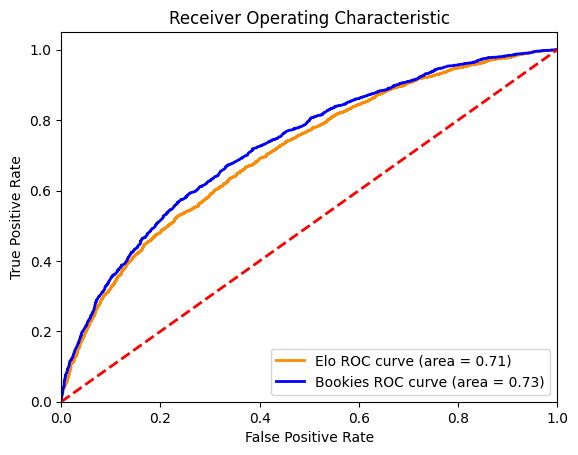

In [8]:
elo_fpr, elo_tpr, elo_thresholds = roc_curve(df['h_win'], df['elo_prob_h'])
elo_roc_auc = auc(elo_fpr, elo_tpr)

bookies_fpr, bookies_tpr, bookies_thresholds = roc_curve(df['h_win'], df['bookies_prob_h'])
bookies_roc_auc = auc(bookies_fpr, bookies_tpr)

plt.figure()
plt.plot(elo_fpr, elo_tpr, color='darkorange', lw=2, 
         label='Elo ROC curve (area = %0.2f)' % elo_roc_auc)
plt.plot(bookies_fpr, bookies_tpr, color='blue', lw=2, 
         label='Bookies ROC curve (area = %0.2f)' % bookies_roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
df_1 = df.copy()
df_1 = df_1[['season', 'game_num_h', 'game_num_a', 'elo_h_before', 'elo_a_before', 'bookies_prob_h', 'h_win']]

In [10]:
df_1.rename(columns={'bookies_prob_h': 'bookies_prob'}, inplace=True)

In [11]:
df_1 = df_1[~df_1['game_num_h'].isin(range(6)) & ~df_1['game_num_a'].isin(range(6))]
df_1 = df_1[~df_1['game_num_h'].isin(range(6)) & ~df_1['game_num_a'].isin(range(6))]
df_1 = df_1[df_1['season'] != '10_11']

In [12]:
test_seasons = ['23_24', '24_25']
val_seasons = ['21_22', '22_23']
train = df_1[~df_1['season'].isin(test_seasons + val_seasons)]
val = df_1[df_1['season'].isin(val_seasons)]


In [13]:
train = train.drop(columns=['game_num_h', 'game_num_a', 'bookies_prob'])
val = val.drop(columns=['game_num_h', 'game_num_a'])

In [14]:
elo_exp_1_run_id = generate_random_string()
print(f"Experiment run ID: {elo_exp_1_run_id}")

run_experiment(
        train,
        val,
        hidden_units=None,
        learning_rate=0.001,
        num_epochs=1000,
        num_samples=100,
        num_batches=1,
        league_tag="EPL",
        run_id=elo_exp_1_run_id,
        run_description="elo experiment 1",
        return_model=False
)

Experiment run ID: dyzd5PJi


Validation Output Sampling Progress: 100%|██████████| 100/100 [00:02<00:00, 41.13it/s]

🏃 View run delightful-vole-391 at: http://localhost:5001/#/experiments/2/runs/74fedbbed9884110a1e81977862987de
🧪 View experiment at: http://localhost:5001/#/experiments/2


In [15]:
run_data = mlflow.search_runs(
    filter_string=f"tags.run_id = '{elo_exp_1_run_id}'"
    )
run_data[['metrics.train_auc', 'metrics.val_auc', 'metrics.train_mse', 'metrics.val_mse']]

,metrics.train_auc,metrics.val_auc,metrics.train_mse,metrics.val_mse
0,0.712094,0.714739,0.215432,0.214519
